In [5]:
import os
import sys
import shutil
import random
import glob
import itertools
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline
print(tf.__version__)

2.3.0


In [8]:
# If using GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print('Num GPUs Available:', len(physical_devices))
if len(physical_devices):
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available: 0


# Data / Preprocessing

In [9]:
train_valid_path = '../../data/asl_alphabet_train'
test_path = '../../data/asl_alphabet_validation'

In [15]:
pp_func = keras.applications.vgg16.preprocess_input
datagen = ImageDataGenerator(
                preprocessing_function=pp_func,
                rescale=1./255,
                validation_split=0.2) 
testgen = ImageDataGenerator(
                preprocessing_function=pp_func,
                rescale=1./255) 

In [27]:
classes = list('ABCDEFGHIJKLMNOPQRSTUVWXYZ')
classes.append('del')
classes.append('space')
classes.append('nothing')

image_size = 128
batch_size = 10

print('done')
train_batches = datagen.flow_from_directory(
                train_valid_path,  #directory for training images
                target_size=(image_size, image_size),
                batch_size=batch_size,
                class_mode='categorical',
                classes=classes,
#                 color_mode='grayscale',
                shuffle=True,
                subset='training')
print('done')
val_batches = datagen.flow_from_directory(
                train_valid_path,  # same directory for testing images
                target_size=(image_size, image_size),
                batch_size=batch_size,
                class_mode='categorical',
                classes=classes,
#                 color_mode='grayscale',
                shuffle=True,
                subset='validation')
print('done')
test_batches = testgen.flow_from_directory(
                test_path,  # directory for validation images
                target_size=(image_size, image_size),
                batch_size=batch_size,
                class_mode='categorical',
                classes=classes,
#                 color_mode='grayscale',
                shuffle=False)
print('done')

done
Found 69601 images belonging to 29 classes.
done
Found 17400 images belonging to 29 classes.
done
Found 30 images belonging to 29 classes.
done


In [28]:
assert train_batches.n == 69601
assert val_batches.n == 17400
assert test_batches.n == 30
assert train_batches.num_classes == val_batches.num_classes == test_batches.num_classes == 29

In [30]:
imgs, labels = next(train_batches)

In [31]:
def plotImages(imgs_arr):
    fig, axs = plt.subplots(1, 10, figsize=(20,20))
    axs = axs.flatten()
    for img, ax in zip(imgs_arr, axs):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

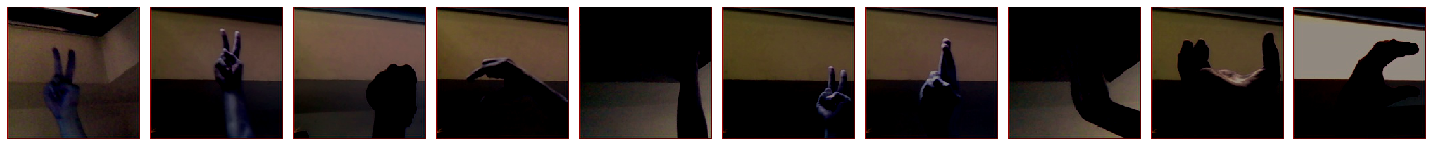

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0.]]


In [32]:
plotImages(imgs)
print(labels)

# Build & Train CNN

In [35]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', input_shape=(image_size,image_size,3)),
    MaxPool2D(pool_size=(2,2), strides=2),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPool2D(pool_size=(2,2), strides=2),
    Flatten(),
    Dense(units=29, activation='softmax')
])

In [36]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 29)                1900573   
Total params: 1,919,965
Trainable params: 1,919,965
Non-trainable params: 0
____________________________________________

In [37]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [38]:
model.fit(x=train_batches, validation_data=val_batches, epochs=10, verbose=2)

Epoch 1/10


KeyboardInterrupt: 